# 나랑 닮은 연예인 찾기
-----

## 모듈 임포트
-----

In [65]:
from PIL import Image
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import face_recognition
import os

In [66]:
font_path = "/usr/share/fonts/truetype/nanum"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

IsADirectoryError: [Errno 21] Is a directory: '/usr/share/fonts/truetype/nanum'

## 1. 사진 모으기
-----

### 1. 정수희 퍼실님이 공유해주신 한국 유명인 얼굴 데이터 셋을 활용하였다.
[정수희 퍼실님 agit 게시글](https://drive.google.com/file/d/1SCNlkW3l9bzsGhzFVk8DmNdfq9D-sey2/view?usp=sharing)

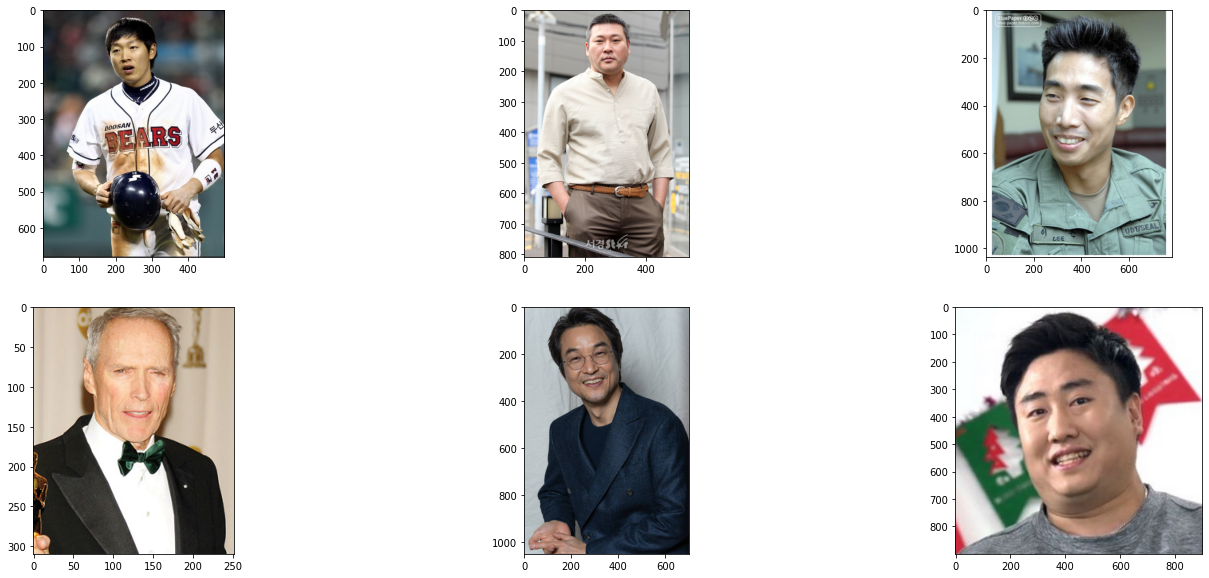

In [3]:
# 이미지 종류별 디렉토리 경로 설정 
dir_path = f'{os.getenv("HOME")}/aiffel/nearest_face/celebrity'
cropped_path = f'{os.getenv("HOME")}/aiffel/nearest_face/cropped_celebrity'
my_dir_path = f'{os.getenv("HOME")}/aiffel/nearest_face/my'

file_list = os.listdir(dir_path)

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path+'/'+file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

## 2. 얼굴영역 자르기
-----

In [35]:
def get_cropped_face(image_file, **kwargs):
    
    '''
    face_location을 얻기 위한 함수
    연예인 사진 이미지(default). 내 사진 이미지, 크롭된 이미지에 모두 사용가능.
    함수 호출시 이미지파일 이름과 함께 아래 인자를 넘겨주어 가져올 이미지의 디렉토리 경로를 설정할 수 있다.
    1 이미지 파일 only
      : 
    2. image_file, my = True
       : 내 사진 이미지가 저장된 디렉토리 경로로 설정
    3. cropped = True
       : 크롭된 연예인 이미지가 저장된 디렉토리 경로로 설정
    '''
    
    # 처리할 이미지의 디렉토리 경로 설정
    image_path = image_file
    if 'my' in kwargs.keys() and kwargs['my'] is True:
        directory_path = my_dir_path
    else: 
        if 'cropped' in kwargs.keys() and kwargs['cropped'] is True:
            directory_path = cropped_path
        else: directory_path = dir_path 
    
    # face_location 구하기
    cropped_face = []
    if os.path.isfile(directory_path+'/'+image_file):
        image = face_recognition.load_image_file(directory_path+'/'+image_path)
        face_location = face_recognition.face_locations(image)
        if not face_location: # default 모델인 hog로 실패시 CNN으로 재시도
            face_location = face_recognition.face_locations(image, model='CNN')
        if face_location: 
            a, b, c, d = face_location[0]
            cropped_face = image[a:c,d:b,:]          
        else: # face_locations()함수로 얼굴인식 실패시 크롭된 이미지의 shape를 face_locations으로 임의 지정 
            c,b = image.shape[:2]
            cropped_face = image[:c, :b ,:]
    return cropped_face

images for cropping:283
cropped images: 283


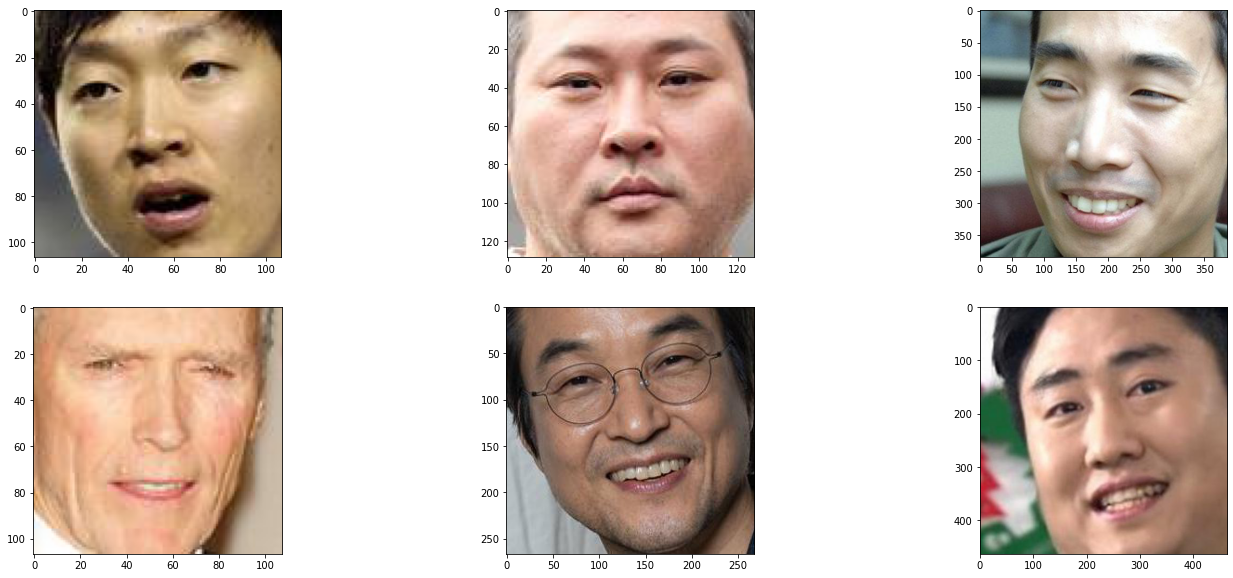

In [34]:
%matplotlib inline
image_files = os.listdir(dir_path)
print(f'images for cropping:{len(image_files)}')

for image_file in os.listdir(dir_path):
    if os.path.isfile(cropped_path+'/'+image_file):
        continue    
    face = get_cropped_face(image_file)
    if str(type(face)) == "<class 'numpy.ndarray'>":
        pillow_image = Image.fromarray(face)
        pillow_image.save(cropped_path+'/'+image_file)

print('cropped images:',len(os.listdir(cropped_path)))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(cropped_path+'/'+os.listdir(cropped_path)[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

## 3. 얼굴영역의 임베딩 추출하기
-----

In [7]:
def get_face_embedding(face):
    '''
    얼굴 영역을 임베딩을 계산하여 반환하는 함수
    ''' 
    embedding = face_recognition.face_encodings(face)
    return embedding

def get_face_embedding_dict():
    '''
    얼굴 영역을 임베딩한 뒤 embedding_dict에 모아 반환하는 함수   
    '''
    file_list = os.listdir(cropped_path)
    embedding_dict = {}
    print(f'file_list: {len(file_list)}EA')
    for file in file_list:
        if not os.path.isfile(cropped_path+'/'+file): # 불러온 것이 디렉토리인 경우 넘기기 
            continue
        face = get_cropped_face(file, cropped=True)
        if str(type(face)) != "<class 'numpy.ndarray'>": # 얼굴인식 실패시 얼굴영역 임의 지정하여 embedding 계산
            embedding = get_face_embedding(face, known_face_locations = [(500,500,3,0)])
        else: embedding = get_face_embedding(face)
        if embedding: # embedding이 생성되었을 때만 embedding_dict에 삽입
            embedding_dict[file[:file.find('.')]] = get_face_embedding(face)[0]
    print(f'embedding_dict: {len(embedding_dict.keys())}EA')        
    return embedding_dict

In [8]:
embedding_dict = get_face_embedding_dict()

file_list: 283EA
embedding_dict: 256EA


In [9]:
embedding_dict['아이즈원민주']

array([-0.09625537,  0.07581477, -0.02568224, -0.13099506, -0.16632532,
       -0.02476943, -0.10436006, -0.0764537 ,  0.13402858, -0.15574186,
        0.12470546, -0.10356865, -0.18848801, -0.01640203, -0.06640944,
        0.23276417, -0.15547061, -0.17560573,  0.00667274,  0.00795719,
        0.10512123,  0.05719842, -0.04854326,  0.09237643, -0.05751549,
       -0.30538467, -0.12671907, -0.0306488 , -0.0255855 , -0.08029158,
       -0.00479561,  0.08893912, -0.16226654,  0.00583318,  0.06006315,
        0.13159801,  0.02045911, -0.06469942,  0.15192096,  0.00179646,
       -0.28377679,  0.06827313,  0.12196408,  0.24001694,  0.14310874,
        0.00777019, -0.01652907, -0.18514188,  0.09585375, -0.13786848,
        0.0581712 ,  0.14320394,  0.05023864,  0.03708532,  0.01483758,
       -0.12459211,  0.10684697,  0.11884519, -0.19426663,  0.00202464,
        0.15452418, -0.05529768,  0.01388687, -0.0971763 ,  0.21838689,
        0.08102496, -0.07290852, -0.27680373,  0.16227137, -0.18

## 4. 모은 연예인들과 비교하기
-----

In [51]:
def get_distance(my_embedding, name2):
    return np.linalg.norm(my_embedding-embedding_dict[name2], ord=2)

def get_sort_key_func(my_embedding):
    def get_distance_from_my_embedding(name2):
        return get_distance(my_embedding, name2)
    return get_distance_from_my_embedding

def get_nearest_face(my_embedding, top_rank=1):
    sort_key_func = get_sort_key_func(my_embedding)
    top_list = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))[:top_rank]
    return top_list

In [63]:
def my_face_embedding(my_path):
    image_path = my_path 
    my_cropped = get_cropped_face(my_path, my = True)
    my_embedding = get_face_embedding(my_cropped)
    return my_embedding

def print_ranks(image, embedding, top_list, **kwargs):
    '''
    순위를 구한 결과를 출력하는 함수
    cols에 순위를 구할 범위를 넣고, 
    '''
    dir_path = os.getenv('HOME')+'/aiffel/nearest_face/celebrity'
    # subplots의 열 입력 받았는지 체크
    if 'cols' not in kwargs.keys():
        cols = 2
    elif kwargs['cols'] is True:  
        cols =  kwargs['cols']
    # subplots 생성
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(24,10))
    for i, ax in enumerate(axes.flatten()):
        if i == 0: # 
            if 'my' in kwargs.keys() and kwargs['my'] is True:
                who = 'My'
            elif 'celeb_name' in kwargs.keys() and kwargs['celeb_name'] is True:
                who = celeb_name
            ax.set_title(f'{who} Image')
            ax.imshow(image)
            continue
        distance = np.linalg.norm(top_list[i-1][1] - embedding, ord=2)
        ax.set_title(f'[ Top {i} ]\nName({top_list[i-1][0]})\nDistance({distance})')
        try:
            file_name = top_list[i-1][0] +'.jpg'
            ax.imshow(img.imread(dir_path+'/'+file_name))
        except: # 파일의 확장자가 jpeg일 때 
            try:
                file_name = file_name[:file_name.find('.')+1]+'jpeg'
                ax.imshow(img.imread(f'{dir_path}/{file_name}'))
            except: # 파일의 확장자가 png일 때 
                file_name = file_name[:file_name.find('.')+1]+'png'
                ax.imshow(img.imread(f'{dir_path}/{file_name}'))
    plt.show()
    fig.tight_layout()

In [57]:
def main():
    my_path = input('내 얼굴이 찍힌 사진의 이름를 입력하세요. \n')
    my_image = img.imread(my_dir_path+'/'+my_path)
    my_embedding = my_face_embedding(my_path)
    top_list = get_nearest_face(my_embedding)
    print_ranks(my_image, my_embedding,top_list, my=True)

내 얼굴이 찍힌 사진의 이름를 입력하세요. 
my_face.jpg


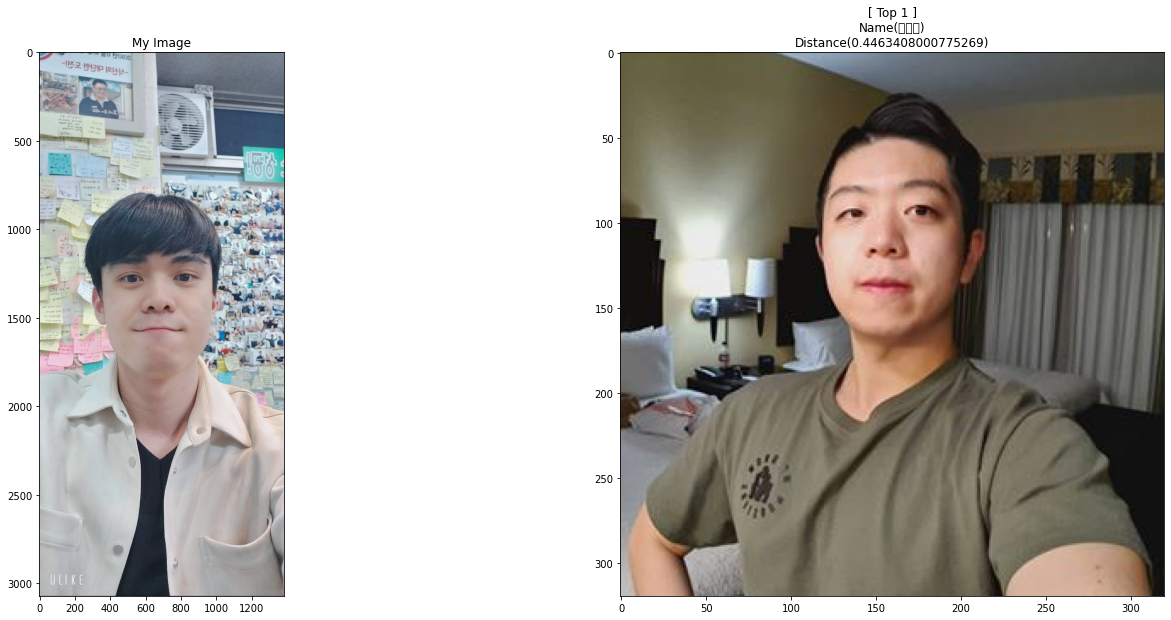

In [62]:
main()

## 5. 다양한 시각화 시도해보기 - 누가 가장 셀럽과 닮았나 게임
-----

1. 참가자들의 사진을 업로드한다.
2. 이번 스테이지의 셀럽을 선택한다.
3. 참가자들의 사진을 셀럽과 닮은 순위대로 정렬하여 출력한다.
4. 1등 참가자의 머리에 왕관을 씌운다.
